In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from imutils.perspective import four_point_transform
from PIL import Image
import time

In [2]:
def initialize_camera(camera_index=0):
    cap = cv2.VideoCapture(camera_index)
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return None
    return cap

def get_image():
    print("Choose 1 for camera, 2 for gallery:")
    choice = input()
    
    if choice == "1":
        cap = initialize_camera()
        if cap:
            # Capture a few frames to allow the camera to adjust
            for i in range(5):
                ret, frame = cap.read()
                if not ret:
                    print(f"Error: Could not read frame {i+1}")
                    continue
                time.sleep(0.1)  # Short sleep between captures

            # Capture the final frame to display
            ret, frame = cap.read()
            if ret:
                print(f"Image loaded successfully from camera")
                # Display the frame using Matplotlib
                img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
                plt.axis('off')
                plt.show()
            else:
                print("Error: Could not read final frame.")
            cap.release()
        return frame
    
    elif choice == '2':
        # Load an existing image
        image_path = input("Enter the path to the image: ")
        image = cv2.imread(image_path)
        
        if image is None:
            print("Failed to load image. Please check the file path.")
        else:
            print(f"Image loaded successfully from {image_path}")
            img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        return image
    
    else:
        print("Invalid choice. Please choose either 1 or 2.")
        return None


In [3]:
def resize(img,width=500):
    h,w,c=img.shape
    height=int((h/w)*width)
    size=(width,height)
    img=cv2.resize(img,(width,height))
    return img,size


def document_scanner(img):
    img,size=resize(img)
    detail=cv2.detailEnhance(img,sigma_s=20,sigma_r=0.15)
    gray=cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY)
    blur=cv2.GaussianBlur(gray,(5,5),0)
    
    #edge detection using cannyedge detection
    edge_image=cv2.Canny(blur,75,200)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("edge_Image")
    plt.imshow(edge_image, cmap='gray')
    plt.axis('off')
    
    #morphological transform
    kernel=np.ones((5,5),np.uint8)
    dilate=cv2.dilate(edge_image,kernel,iterations=1)
    closing=cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("closing_Image")
    plt.imshow(closing, cmap='gray')
    plt.axis('off')
    
    #find the contours
    contours,hire=cv2.findContours(closing,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    contours=sorted(contours,key=cv2.contourArea,reverse=True)
    for contour in contours:
        peri=cv2.arcLength(contour,True)
        approx=cv2.approxPolyDP(contour,0.02*peri,True)
        if len(approx)==4:
            four_points=np.squeeze(approx)
            break
    #cv2.drawContours(img,[four_points],-1,(0,255,0),3)

    multiplier=img.shape[1]/size[0]
    fourpoints=four_points*multiplier
    fourpoints=fourpoints.astype(int)
    wrap_image=four_point_transform(img,fourpoints)
    
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("wrapped_Image")
    plt.imshow(wrap_image, cmap='gray')
    plt.axis('off')
    
    return wrap_image,fourpoints

In [4]:
def saving_image(img):
    output_path='scanned_document.png'
    cv2.imwrite(output_path,img)
    pil_image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    pdf_output_path = output_path.replace('.png', '.pdf')
    pil_image.save(pdf_output_path, 'PDF', resolution=100.0)
    
    print(f"Scanned document saved as {output_path} and {pdf_output_path}")

Choose 1 for camera, 2 for gallery:
2
Enter the path to the image: C:\\Users\\HP\\Desktop\\bookpage4.jpg
Image loaded successfully from C:\\Users\\HP\\Desktop\\bookpage4.jpg


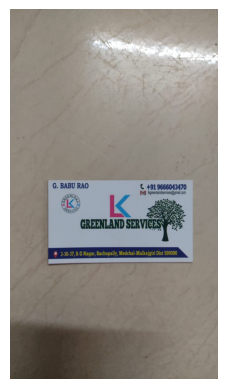

Scanned document saved as scanned_document.png and scanned_document.pdf


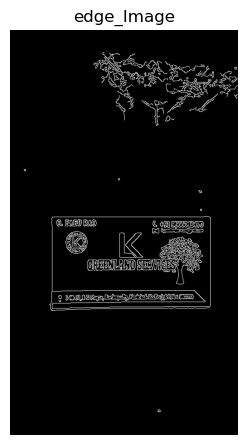

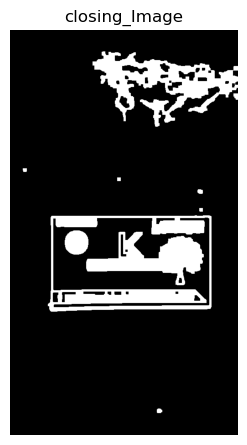

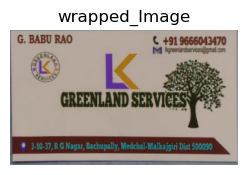

In [6]:
image = get_image()
scanned_image,edges=document_scanner(image)
save_image=saving_image(scanned_image)